# ADMM applied in Neural Networks with Mnist dataset


In [86]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from NeuralNetwork.data_utils import *

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing and Loading of dataset

In [87]:
from NeuralNetwork.data_utils import *
mnistDir = "NeuralNetwork/MnistData"
datasets = getMnistDataSets(mnistDir,valSize=0)
datasets

{'test': <NeuralNetwork.data_utils.DataSet instance at 0x1051eda28>,
 'train': <NeuralNetwork.data_utils.DataSet instance at 0x10ba1b830>}

In [88]:
# Load Mnist Data
mnistDir = "NeuralNetwork/MnistData"
X_train,Y_train,X_test,Y_test = getMnistData(mnistDir)

# Check the size of the training and test data.
print 'Training data shape: ', X_train.shape, X_train.dtype
print 'Training labels shape: ', Y_train.shape,Y_train.dtype
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Training data shape:  (60000, 28, 28) float64
Training labels shape:  (60000,) int64
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


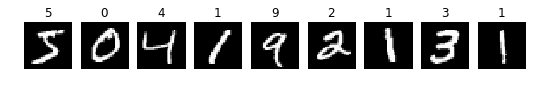

In [89]:
# Display part of the Mnist data
for xi in range(0,9):
    plt.subplot(1,10,xi+1)
    plt.imshow(X_train[xi])
    plt.axis('off')
    plt.title(Y_train[xi])

## Predefined Functions

In [90]:
# Get MiniPatch
def getMiniPatch(X_train, Y_train, X_test, Y_test, trNum, teNum, transposed):
    # Subsample the data for more efficient code execution 
    trainNum = trNum
    mask = range(trainNum)
    #mask = range(5000,trainNum)
    Xtr = X_train[mask]
    Ytr = Y_train[mask]
    
    testNum = teNum
    mask = range(testNum)
    #mask = range(5000,5000+testNum)
    Xte = X_test[mask]
    Yte = Y_test[mask]
    
    # Reshape the image data into rows
    Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
    Xte = np.reshape(Xte, (Xte.shape[0], -1))
   
    # print Xtr.shape, Xte.shape
    if not transposed:
        return Xtr, Xtr, Ytr, Yte
    else:
        return preprocess(Xtr.T), Xte.T, Ytr, Yte

def preprocess(X):
    
#     # return X
#     X = X.astype(np.float64)
#     # Mean subtraction
#     X -= np.mean(X)  
#     # Normalization
   # X /= np.std(X, axis = 0)
    return X

## Test NeuralNetwork


In [91]:
from NeuralNetwork.neural_network import *
import time


case = [(5000,1000)]#,(5000,50)]#,(500,10),(5000,10),(5000,500),(20000,500),(20000, 2000)]
i = 0
for la in lam:
    print 'hasLambda = ',la
    for (trNum,teNum) in case:
        X_tr, X_te, Y_tr, Y_te = getMiniPatch(X_train, Y_train, X_train, Y_train, trNum, teNum, 1)
        print 'Xtr: ', X_tr.shape, 'Xte: ', X_te.shape, 'Ytr: ', Y_tr.shape, 'Yte: ', Y_te.shape
        
        # Initialize network
        hiddenLayer = [300]
        classNum = 10 
        epsilon= 0.0001 
        #epsilon = np.sqrt(2.0/trNum)
        network = NeuralNetwork(X_tr, Y_tr, classNum, hiddenLayer, epsilon)
        # Train
        weightConsWeight = 10
        activConsWeight = 15
        iterNum = 20
        hasLambda = False
        tic = time.time()
        calLoss = True
        
        """ 
        Input:
        weightConsWeight, activConsWeight
        iterNum:    iteration to perform Admm updates
        hasLambda:  whether include Lambda update
        lossType:   one of {'hinge', 'msq', 'smx'}, default is 'smx'
        minMethod:  if lossType is 'smx', the method to minimize the zLastUpdate has to be specified (for it's not in closed form), 
                    it can be one of {'prox','gd','newton'}, default is 'prox';
        tau, ite:   if lossType is 'smx', the step size and iteration of gradient descent/proximal gradient have to be specified, 
                    default: tau=0.01, ite=25; 
        """
        #network.train(weightConsWeight, activConsWeight, iterNum, hasLambda,lossType = 'hinge')
        %prun network.train2(weightConsWeight, activConsWeight, iterNum, hasLambda, calLoss, lossType = 'smx', minMethod = 'prox', tau= 0.01, ite= 25)
        toc = time.time()
        print 'Total training time: %fs' % (toc - tic)

        # Predict
        Ypred,z = network.predict(X_te)
        print ',,,',Ypred.shape
        print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)
        
        L = len(hiddenLayer)
        if calLoss:
            fig = plt.figure()
            gs = gridspec.GridSpec(5,L)
          
            dataLoss = fig.add_subplot(gs[0,:])
            dataLoss.set_title('loss function')
            dataLoss.plot(network.dataLoss, 'k-')

            for l in range(0,L):
                aloss = fig.add_subplot(gs[1,l])
                aloss.set_title('constraint a = hz, layer = %d' % (l+1))
                aloss.plot(network.aConstrLoss[l], 'g-')
                
                zloss = fig.add_subplot(gs[2,l])
                zloss.set_title('constraint z = wa, layer = %d' % (l+1))
                zloss.plot(network.zConstrLoss[l], 'b-')
                
#             lag = fig.add_subplot(gs[3,:])
#             lag.set_title('lagrange term')
#             lag.plot(network.lagraLoss, 'r-')

            
            zLLoss = fig.add_subplot(gs[3,:])
            zLLoss.set_title('output layer zL')
            zLLoss.plot(network.zConstrLoss[L], 'k-')
            
            total = fig.add_subplot(gs[4,:])
            total.set_title('total loss ')
            total.plot(network.totalLoss, 'r-')
            
            plt.tight_layout()
            plt.show()
        


hasLambda =  True
Xtr:  (784, 5000) Xte:  (784, 1000) Ytr:  (5000,) Yte:  (1000,)
[]   [[]]   [[], []]
Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]


KeyboardInterrupt: 

In [84]:
X_tr, X_te, Y_tr, Y_te = getMiniPatch(X_train, Y_train, X_test, Y_test, 6000, 1000, 1)
Ypred,x = network.predict(X_te)
print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)

(300, 784)
Prediction accuracy: 0.593000
